Load data

In [1]:
#add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm
import time as time
start = time.time()
#add data
datos = pd.read_csv("datasets/Viajes MEX-TOL.csv")
#convert to utm
latitudes = np.array(datos["latitud"])
longitudes = np.array(datos["longitud"])
utms = utm.from_latlon(latitudes,longitudes,14,"Q") #14Q for Mexico
datos_f = datos.copy()
datos_f["utm_x"] = utms[0]
datos_f["utm_y"] = utms[1]


min_longitud = -99.64
max_longitud = -99.39
datos_f = datos_f[datos_f['longitud'] > min_longitud]
datos_f = datos_f[datos_f['longitud'] < max_longitud]
datos_f = datos_f[datos_f['longitud'] < max_longitud]
datos_f = datos_f.reset_index()

datos_f = datos_f.drop(["l","latitud","longitud","fecha","hora"],axis=1)
datos_f = datos_f.rename(columns={"altitud": "height"})
#lag point coordinates
datos_l = datos_f.copy()
datos_l["next_utm_x"] = datos_f["utm_x"].shift(-1)
datos_l["next_utm_y"] = datos_f["utm_y"].shift(-1)
datos_l["next_height"] = datos_f["height"].shift(-1)
#calculate distances and slopes
datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["next_utm_x"])**2 + (datos_l["utm_y"]-datos_l["next_utm_y"])**2)
datos_l["slope"] = (datos_l["next_height"]-datos_l["height"])/datos_l["distance"] 
datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
plt.plot(datos_l["sum_distance"],datos_l["height"])
plt.show()    
print(datos_l)
stop = time.time()
print(stop-start,"ms")

/Users/jayguru/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jayguru/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jayguru/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


<Figure size 640x480 with 1 Axes>

      index  secuencia       height          utm_x         utm_y  \
0      4364      16159  3005.483154  459005.271210  2.134010e+06   
1      4365      16160  3005.680908  458979.520032  2.134006e+06   
2      4366      16161  3006.632813  458953.663777  2.134001e+06   
3      4367      16162  3007.304932  458928.228505  2.133996e+06   
4      4368      16163  3007.375977  458902.898782  2.133992e+06   
...     ...        ...          ...            ...           ...   
1663   6027      17822  2655.105469  433618.419221  2.131161e+06   
1664   6028      17823  2655.105225  433618.209057  2.131161e+06   
1665   6029      17824  2655.092529  433617.473079  2.131161e+06   
1666   6030      17825  2655.127441  433616.421051  2.131161e+06   
1667   6031      17826  2655.086670  433615.475312  2.131161e+06   

         next_utm_x    next_utm_y  next_height   distance     slope  \
0     458979.520032  2.134006e+06  3005.680908  26.196697  0.007549   
1     458953.663777  2.134001e+06  3006.6

Clustering

In [2]:
import seaborn as sns

In [3]:
def sdd_clust(data, tol):
    heights = data["height"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters
    return data

In [4]:
def tol_adjust (data, tol=1.6):
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    table = data2.value_counts()
    frec = datos_l.cluster.value_counts().to_numpy()
    n = frec[frec<2].shape[0]
  print(tol)
  return data2
   


In [5]:
data_clustered = tol_adjust(datos_l, 1.6)

2.600000000000001


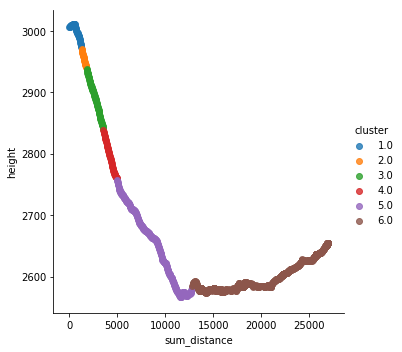

In [6]:
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)